In [151]:
%matplotlib inline
import os

from pathlib import Path
from tensorflow.python.summary.summary_iterator import summary_iterator

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [84]:
notebooks_dir = Path(os.path.abspath(''))
logs_dir = notebooks_dir.parent / 'hac' / 'logs'
logs_dagger_dir = notebooks_dir.parent / 'hac' / 'logsDagger'
media_dir = notebooks_dir.parent / 'media'


# HAC-General With Teacher

In [87]:
lunar_lander_event_file1 = str(logs_dir / 'LunarLanderContinuous-v2' / 'May28_17-19-13' / 'events.out.tfevents.1590679155.thebox.1855205.0')
lunar_lander_event_file2 = str(logs_dir / 'LunarLanderContinuous-v2' / 'May28_19-13-32' / 'events.out.tfevents.1590686013.thebox.2105456.0')
lunar_lander_event_files = [lunar_lander_event_file1, lunar_lander_event_file2]

mountain_car_event_file1 = str(logs_dir / 'MountainCarContinuous-v0' / 'May30_01-23-42' / 'events.out.tfevents.1590794626.thebox.1200713.0')
mountain_car_event_files = [mountain_car_event_file1]

In [104]:
# This example supposes that the events file contains summaries with a
# summary value tag 'loss'.  These could have been added by calling
# `add_summary()`, passing the output of a scalar summary op created with
# with: `tf.scalar_summary(['loss'], loss_tensor)`.

def get_vals_with_tag(event_file_name, tag_name):
    values = []
    for index, e in enumerate(summary_iterator(event_file_name)):
        for v in e.summary.value:
            if v.tag == tag_name:
                values.append(v.simple_value)
    
    return values

def get_all_tags(event_file_name):
    tags = set()
    for index, e in enumerate(summary_iterator(event_file_name)):
        for v in e.summary.value:
            tags.add(v.tag)
            
    return tags

In [155]:
sns.set()
sns.set_style("whitegrid")

def make_running_rewards_plot(event_files, env_name, reward_threshold, algorithm, scaling_factor = 1):
    running_rewards_list = [get_vals_with_tag(event_file, 'Progress/Running reward') for event_file in event_files]
    display_running_rewards_plot(running_rewards_list, env_name, reward_threshold, algorithm, scaling_factor)
    
def display_running_rewards_plot(running_rewards_list, env_name, reward_threshold, algorithm, scaling_factor = 1, run_label=None):
    plt.figure(figsize=(12, 6))
    for index, running_rewards in enumerate(running_rewards_list):
        plt.plot(running_rewards, label=run_label or f"Run {index}")
        

    plt.xlabel("Episode")
    if scaling_factor == 1:
        plt.ylabel("Running reward")
    else:
        plt.ylabel(f"Running reward (scaling factor = {scaling_factor})")
        
    plt.title(f"Evolution of the running reward - {env_name} environment")
    plt.axhline(y=reward_threshold, color='r', linestyle='-', label="Success threshold")
    plt.legend()
    plt.savefig(media_dir / f"RunningReward{env_name.replace(' ', '')}{algorithm}.png")
    plt.show()

def display_performance_plot(running_rewards_list, env_name, reward_threshold, algorithm, scaling_factor = 1, run_label=None, training=True, episode_multiplier=1, quantity=None):
    x = [i * episode_multiplier + 1 for i in range(len(running_rewards_list[0]))]
    
    plt.figure(figsize=(12, 6))
    for index, running_rewards in enumerate(running_rewards_list):
        plt.plot(x, running_rewards, label=run_label or f"Run {index}")
    
    

    plt.xlabel("Episode")
    if scaling_factor == 1:
        plt.ylabel(f"{quantity or 'Episode reward'}")
    else:
        plt.ylabel(f"{quantity or 'Episode reward'} (scaling factor = {scaling_factor})")
        
    train_str = "training" if training else "testing"
    
    plt.title(f"Episode reward during a {train_str} phase - {env_name} environment")
    plt.axhline(y=reward_threshold, color='r', linestyle='-', label="Success threshold")
    plt.legend()
    plt.savefig(media_dir / f"EpisodeReward{env_name.replace(' ', '')}{algorithm}{train_str.capitalize()}.png")
    plt.show()

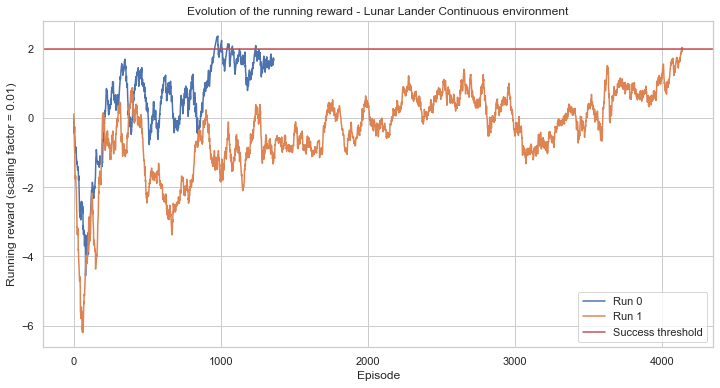

In [82]:
make_running_rewards_plot(
    lunar_lander_event_files, 
    env_name='Lunar Lander Continuous', 
    reward_threshold=2, 
    algorithm = 'HacGeneralWithTeacher',
    scaling_factor=0.01
)

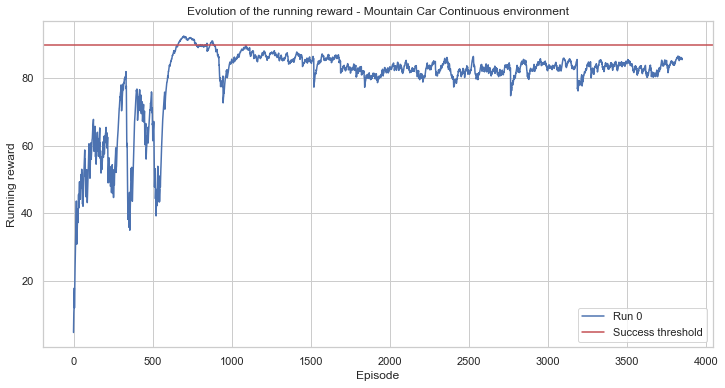

In [83]:
make_running_rewards_plot(
    mountain_car_event_files, 
    env_name='Mountain Car Continuous', 
    reward_threshold=90, 
    algorithm = 'HacGeneralWithTeacher',
)

# Dagger

In [119]:
lunar_lander_event_file_dagger = str(logs_dagger_dir / 'LunarLanderContinuous-v2' / 'Jun15_23-40-22' / 'events.out.tfevents.1592257223.thebox.2492523.0')
lunar_lander_event_files_dagger = [lunar_lander_event_file_dagger]
lunar_lander_event_file_dagger

'/mnt/199853D54DF008DD/MEGAsync/aVUB/Memoire/thesisgregorybonaert/hac/logsDagger/LunarLanderContinuous-v2/Jun15_23-40-22/events.out.tfevents.1592257223.thebox.2492523.0'

In [120]:
get_all_tags(lunar_lander_event_file_dagger)

{'TestingPhase/Episode reward',
 'TestingPhase/Eval Mean Num Steps',
 'TestingPhase/Eval Mean Percent goals reached',
 'TestingPhase/Eval Mean Reward',
 'TestingPhase/Eval Std Dev Num Steps',
 'TestingPhase/Eval Std Dev Reward',
 'TestingPhase/Eval Std Percent goals reached',
 'TestingPhase/Percent goals reached',
 'TestingPhase/Steps in episode',
 'TrainingPhase/Episode reward',
 'TrainingPhase/Eval Mean Num Steps',
 'TrainingPhase/Eval Mean Percent goals reached',
 'TrainingPhase/Eval Mean Reward',
 'TrainingPhase/Eval Std Dev Num Steps',
 'TrainingPhase/Eval Std Dev Reward',
 'TrainingPhase/Eval Std Percent goals reached',
 'TrainingPhase/Percent goals reached',
 'TrainingPhase/Steps in episode'}

In [123]:
running_rewards_list = [get_vals_with_tag(event_file, 'TestingPhase/Episode reward') for event_file in lunar_lander_event_files_dagger]
running_rewards_list;

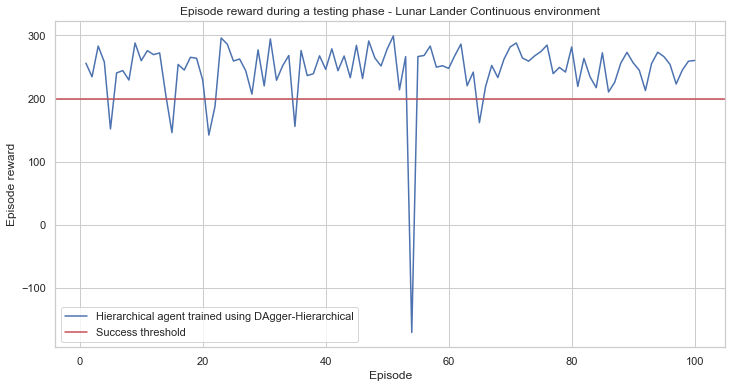

In [157]:
display_performance_plot(
    running_rewards_list, 
    env_name='Lunar Lander Continuous', 
    reward_threshold=200, 
    algorithm = 'DAgger-Hierarchical',
    run_label = "Hierarchical agent trained using DAgger-Hierarchical",
    training = False
)

In [149]:
running_rewards_list_train = [get_vals_with_tag(event_file, 'TrainingPhase/Eval Mean Reward') for event_file in lunar_lander_event_files_dagger]
running_rewards_list_train;

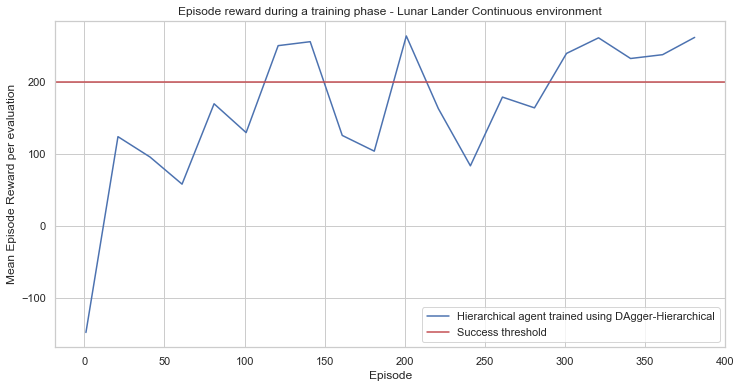

In [156]:
display_performance_plot(
    running_rewards_list_train, 
    env_name='Lunar Lander Continuous', 
    reward_threshold=200, 
    algorithm = 'DAgger-Hierarchical',
    run_label = "Hierarchical agent trained using DAgger-Hierarchical",
    quantity = "Mean Episode Reward per evaluation",
    episode_multiplier = 20,
    training = True
)